# Image classification with TensorFlow Lite Model Maker

The [TensorFlow Lite Model Maker library](https://www.tensorflow.org/lite/guide/model_maker) simplifies the process of adapting and converting a TensorFlow neural-network model to particular input data when deploying this model for on-device ML applications.

This notebook shows an end-to-end example that utilizes this Model Maker library to illustrate the adaption and conversion of a commonly-used image classification model to classify flowers on a mobile device.

## Prerequisites

To run this example, we first need to install several required packages, including Model Maker package that in GitHub [repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker).

In [ ]:
!sudo apt -y install libportaudio2


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 70 not upgraded.


In [ ]:
!pip install -q tflite-model-maker

Import the required packages.

In [ ]:
import os

import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')

from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

import matplotlib.pyplot as plt

In [ ]:
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()


In [ ]:
BUCKET_NAME = 'project_name'

GCS_BUCKET = f'gs://{BUCKET_NAME}'
!gsutil mb -p $GCP_PROJECT_ID $GCS_BUCKET

Creating gs://fish_size_project_data/...
ServiceException: 409 A Cloud Storage bucket named 'fish_size_project_data' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


In [ ]:
# install gcsfuse on colab.
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  60404      0 --:--:-- --:--:-- --:--:-- 60404
OK
70 packages can be upgraded. Run 'apt list --upgradable' to see them.
gcsfuse is already the newest version (0.41.1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 70 not upgraded.


In [ ]:
!mkdir deeper_data
!gcsfuse --implicit-dirs fish_size_project_data deeper_data

mkdir: cannot create directory ‘deeper_data’: File exists
2022/05/16 09:08:18.569588 Start gcsfuse/0.41.1 (Go version go1.17.6) for app "" using mount point: /content/deeper_data
2022/05/16 09:08:18.585287 Opening GCS connection...
2022/05/16 09:08:18.743761 Mounting file system "fish_size_project_data"...
2022/05/16 09:08:18.744297 File system has been successfully mounted.


## Model training and testing



### Step 1: Load Input Data Specific

The dataset should have the following directory structure:

<pre>
<b>fish_photos</b>
|__ <b>Abramis brama</b>
    |______ 100080576_f52e8ee070_n.jpg
    |______ 14167534527_781ceb1b7a_n.jpg
    |______ ...
|__ <b>Cyprinus carpio</b>
    |______ 10043234166_e6dd915111_n.jpg
    |______ 1426682852_e62169221f_m.jpg
    |______ ...
|__ <b>Esox lucius</b>
    |______ 102501987_3cdb8e5394_n.jpg
    |______ 14982802401_a3dfb22afb.jpg
    |______ ...
|__ <b>Micropterus salmoides</b>
    |______ 12471791574_bb1be83df4.jpg
    |______ 15122112402_cafa41934f.jpg
    |______ ...
|__ <b>Perca fluviatilis</b>
    |______ 13976522214_ccec508fe7.jpg
    |______ 14487943607_651e8062a1_m.jpg
    |______ ...
</pre>

If you prefer not to upload your images to the cloud, you could try to run the library locally following the [guide](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) in GitHub.

In [ ]:
cd deeper_data/annotated_images_pilot_by_spp_augmented

/content/deeper_data/MonthlyDeeperData/2021-08-01/images


In [ ]:
image_path = './'

Use `DataLoader` class to load data.

As for `from_folder()` method, it could load data from the folder. It assumes that the image data of the same class are in the same subdirectory and the subfolder name is the class name. Currently, JPEG-encoded images and PNG-encoded images are supported.

In [ ]:
data = DataLoader.from_folder(image_path)

INFO:tensorflow:Load image with size: 4809, num_label: 6, labels: Abramis brama, Cyprinus carpio, Esox lucius, Micropterus salmoides, Perca fluviatilis, Sander lucioperca.


Split it to training data (80%), validation data (10%, optional) and testing data (10%).

In [ ]:
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

Show 25 image examples with labels.

In [ ]:
plt.figure(figsize=(25,25))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

### Step 2: Customize the TensorFlow Model

Currently, Tensorflow Lite support several models such as  EfficientNet-Lite* models, MobileNetV2, ResNet50 as pre-trained models for image classification. But it is very flexible to add new pre-trained models to this library with just a few lines of code.


The following walks through this end-to-end example step by step to show more detail.

Create a custom image classifier model based on the loaded data. The default model is EfficientNet-Lite0.


**Other models**

This library supports EfficientNet-Lite models only. For MobileNetV2 and ResNet50 need to use other libraries. EfficientNet-Lite are a family of image classification models that could achieve state-of-art accuracy and suitable for Edge devices. The default model is EfficientNet-Lite0.

We could switch model to MobileNetV2 by just setting parameter model_spec to the MobileNetV2 model specification in create method.

List of models names:

| Model architecture |
|--------------------|
| mobilenet_v2 |
| efficientnet_lite0 |
| resnet_50 |


**Change the training hyperparameters**

We could also change the training hyperparameters like `epochs`, `dropout_rate` and `batch_size` that could affect the model accuracy. The model parameters you can adjust are:


*   `epochs`: more epochs could achieve better accuracy until it converges but training for too many epochs may lead to overfitting.
*   `dropout_rate`: The rate for dropout, avoid overfitting. None by default.
*   `batch_size`: number of samples to use in one training step.  None by default.
*   `validation_data`: Validation data. If None, skips validation process. None by default.
*   `train_whole_model`: If true, the Hub module is trained together with the classification layer on top. Otherwise, only train the top classification layer. None by default.
*   `learning_rate`: Base learning rate. None by default.
*   `momentum`: a Python float forwarded to the optimizer. Only used when
      `use_hub_library` is True. None by default.
*   `shuffle`: Boolean, whether the data should be shuffled. False by default.
*   `use_augmentation`: Boolean, use data augmentation for preprocessing. False by default.
*   `use_hub_library`: Boolean, use `make_image_classifier_lib` from tensorflow hub to retrain the model. This training pipeline could achieve better performance for complicated dataset with many categories. True by default. 
*   `warmup_steps`: Number of warmup steps for warmup schedule on learning rate. If None, the default warmup_steps is used which is the total training steps in two epochs. Only used when `use_hub_library` is False. None by default.
*   `model_dir`: Optional, the location of the model checkpoint files. Only used when `use_hub_library` is False. None by default.

Parameters which are None by default like `epochs` will get the concrete default parameters in [make_image_classifier_lib](https://github.com/tensorflow/hub/blob/02ab9b7d3455e99e97abecf43c5d598a5528e20c/tensorflow_hub/tools/make_image_classifier/make_image_classifier_lib.py#L54) from TensorFlow Hub library or  [train_image_classifier_lib](https://github.com/tensorflow/examples/blob/f0260433d133fd3cea4a920d1e53ecda07163aee/tensorflow_examples/lite/model_maker/core/task/train_image_classifier_lib.py#L61).

For example, we could train with more epochs.




The **`create` function** is the critical part of this library. It uses transfer learning with a pretrained model similar to the [tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning).

The `create` function contains the following steps:

1.   Split the data into training, validation, testing data according to parameter `validation_ratio` and `test_ratio`. The default value of `validation_ratio` and `test_ratio` are `0.1` and `0.1`.
2.   Download a [Image Feature Vector](https://www.tensorflow.org/hub/common_signatures/images#image_feature_vector) as the base model from TensorFlow Hub. The default pre-trained model is  EfficientNet-Lite0.
3.   Add a classifier head with a Dropout Layer with `dropout_rate` between head layer and pre-trained model. The default `dropout_rate` is the default `dropout_rate` value from [make_image_classifier_lib](https://github.com/tensorflow/hub/blob/master/tensorflow_hub/tools/make_image_classifier/make_image_classifier_lib.py#L55) by TensorFlow Hub.
4.   Preprocess the raw input data. Currently, preprocessing steps including normalizing the value of each image pixel to model input scale and resizing it to model input size.   EfficientNet-Lite0 have the input scale `[0, 1]` and the input image size `[224, 224, 3]`.
5.   Feed the data into the classifier model. By default, the training parameters such as training epochs, batch size, learning rate, momentum are the default values from [make_image_classifier_lib](https://github.com/tensorflow/hub/blob/master/tensorflow_hub/tools/make_image_classifier/make_image_classifier_lib.py#L55) by TensorFlow Hub. Only the classifier head is trained.




In [ ]:
# model = image_classifier.create(train_data, validation_data=validation_data)
model = image_classifier.create(train_data, model_spec=model_spec.get('efficientnet_lite0'), validation_data=validation_data, batch_size=32, epochs=20)

INFO:tensorflow:Retraining the models...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 3,420,710
Trainable params: 7,686
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


120/120 [==============================] - 502s 4s/step - loss: 1.1627 - accuracy: 0.6531 - val_loss: 0.8766 - val_accuracy: 0.8212
Epoch 2/20
120/120 [==============================] - 338s 3s/step - loss: 0.8724 - accuracy: 0.8042 - val_loss: 0.8041 - val_accuracy: 0.8628
Epoch 3/20
120/120 [==============================] - 313s 3s/step - loss: 0.8062 - accuracy: 0.8398 - val_loss: 0.7729 - val_accuracy: 0.8773
Epoch 4/20
120/120 [==============================] - 340s 3s/step - loss: 0.7751 - accuracy: 0.8578 - val_loss: 0.7490 - val_accuracy: 0.9023
Epoch 5/20
120/120 [==============================] - 332s 3s/step - loss: 0.7511 - accuracy: 0.8753 - val_loss: 0.7340 - val_accuracy: 0.9002
Epoch 6/20
120/120 [==============================] - 335s 3s/step - loss: 0.7348 - accuracy: 0.8841 - val_loss: 0.7278 - val_accuracy: 0.9023
Epoch 7/20
120/120 [==============================] - 305s 3s/step - loss: 0.7197 - accuracy: 0.8898 - val_loss: 0.7159 - val_accuracy: 0.9085
Epoch 8/20

Have a look at the detailed model structure.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 3,420,710
Trainable params: 7,686
Non-trainable params: 3,413,024
_________________________________________________________________


### Step 3: Evaluate the Customized Model

Evaluate the result of the model, get the loss and accuracy of the model.

In [ ]:
loss, accuracy = model.evaluate(test_data)

16/16 [==============================] - 147s 3s/step - loss: 0.7073 - accuracy: 0.9064


We could plot the predicted results in 100 test images. Predicted labels with red color are the wrong predicted results while others are correct.

In [ ]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(40, 40))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(100)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

In [ ]:
# Import pandas library
import pandas as pd

# predicts = model.predict_top_k(test_data)
appended_data = []

for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(100)):
  predicted_label = predicts[i][0][0]
  # expected_label = test_data.index_to_label[label.numpy()]
  # store DataFrame in list
  appended_data.append(predicted_label)
  # appended_data.append(expected_label)

df_predicted = pd.DataFrame(appended_data, columns = ['predicted'])


In [ ]:
# predicts = model.predict_top_k(test_data)
appended_data = []

for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(100)):
  # predicted_label = predicts[i][0][0]
  expected_label = test_data.index_to_label[label.numpy()]
  # store DataFrame in list
  # appended_data.append(predicted_label)
  appended_data.append(expected_label)

df_expected = pd.DataFrame(appended_data, columns = ['expected'])

In [ ]:
df_confusion = pd.concat([df_predicted, df_expected], axis=1)
df_confusion

,predicted,expected
0,Esox lucius,Esox lucius
1,Cyprinus carpio,Cyprinus carpio
2,Perca fluviatilis,Perca fluviatilis
3,Abramis brama,Abramis brama
4,Esox lucius,Esox lucius
...,...,...
95,Perca fluviatilis,Perca fluviatilis
96,Perca fluviatilis,Perca fluviatilis
97,Esox lucius,Esox lucius
98,Cyprinus carpio,Cyprinus carpio


In [ ]:
df_confusion.to_csv("../../df_confusion.csv")

In [ ]:
df_prob_predicts = pd.DataFrame(predicts)
df_prob_predicts.to_csv("../../df_prob_predicts.csv")

If the accuracy doesn't meet the app requirement, one could refer to [Advanced Usage](#scrollTo=zNDBP2qA54aK) to explore alternatives such as changing to a larger model, adjusting re-training parameters etc.

### Step 4: Confusion matrix

In [ ]:
import pandas as pd
df_confusion = pd.read_csv("../../df_confusion.csv", index_col=False)
df_confusion.head(5)

,Unnamed: 0,predicted,expected
0,0,Esox lucius,Esox lucius
1,1,Cyprinus carpio,Cyprinus carpio
2,2,Perca fluviatilis,Perca fluviatilis
3,3,Abramis brama,Abramis brama
4,4,Esox lucius,Esox lucius


In [ ]:
df1 = df_confusion['predicted'].value_counts().rename_axis('predicted').reset_index(name='N. of predicted')
df1

,predicted,N. of predicted
0,Esox lucius,29
1,Cyprinus carpio,25
2,Perca fluviatilis,21
3,Micropterus salmoides,11
4,Sander lucioperca,8
5,Abramis brama,6


In [ ]:
df2 = df_confusion['expected'].value_counts().rename_axis('expected').reset_index(name='N. of expected')
df2

,expected,N. of expected
0,Esox lucius,29
1,Cyprinus carpio,24
2,Perca fluviatilis,21
3,Micropterus salmoides,11
4,Sander lucioperca,9
5,Abramis brama,6


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(df_confusion["expected"], df_confusion["predicted"])
confusion_matrix

array([[ 5,  0,  0,  0,  1,  0],
       [ 0, 24,  0,  0,  0,  0],
       [ 0,  0, 27,  0,  1,  1],
       [ 0,  0,  0, 11,  0,  0],
       [ 0,  1,  0,  0, 18,  2],
       [ 1,  0,  2,  0,  1,  5]])

In [ ]:
confusion_matrix.sum()

100

In [ ]:
confusion_normalized = confusion_matrix.astype("float") / confusion_matrix.sum(axis=1)[:,None]
confusion_normalized

array([[0.83333333, 0.        , 0.        , 0.        , 0.16666667,
        0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.93103448, 0.        , 0.03448276,
        0.03448276],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        ],
       [0.        , 0.04761905, 0.        , 0.        , 0.85714286,
        0.0952381 ],
       [0.11111111, 0.        , 0.22222222, 0.        , 0.11111111,
        0.55555556]])

Text(0.5, 15.0, 'Predicted label')

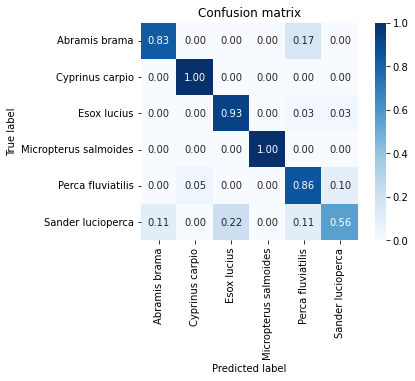

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

axis_labels = ["Abramis brama", "Cyprinus carpio", "Esox lucius", "Micropterus salmoides", "Perca fluviatilis", "Sander lucioperca"]
ax = sns.heatmap(confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
                 cmap='Blues', annot=True, fmt='.2f', square=True)
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")


### Step 5: Export to TensorFlow Lite Model

Convert the trained model to TensorFlow Lite model format with [metadata](https://www.tensorflow.org/lite/convert/metadata) so that you can later use in an on-device ML application. The label file and the vocab file are embedded in metadata. The default TFLite filename is `model.tflite`.

In many on-device ML application, the model size is an important factor. Therefore, it is recommended that you apply quantize the model to make it smaller and potentially run faster.
The default post-training quantization technique is full integer quantization for the image classification task.

In [ ]:
model.export(export_dir='../../', tflite_filename='model_efficientnet_batch32_epochs20.tflite')

INFO:tensorflow:Assets written to: /tmp/tmpjfdocx4x/assets


INFO:tensorflow:Assets written to: /tmp/tmpjfdocx4x/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmpn01xoqeb/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmpn01xoqeb/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ../../model_efficientnet_batch32_epochs20.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ../../model_efficientnet_batch32_epochs20.tflite


See [example applications and guides of image classification](https://www.tensorflow.org/lite/models/image_classification/overview#example_applications_and_guides) for more details about how to integrate the TensorFlow Lite model into mobile apps.

This model can be integrated into an Android or an iOS app using the [ImageClassifier API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/image_classifier) of the [TensorFlow Lite Task Library](https://www.tensorflow.org/lite/inference_with_metadata/task_library/overview).

The allowed export formats can be one or a list of the following:

*   `ExportFormat.TFLITE`
*   `ExportFormat.LABEL`
*   `ExportFormat.SAVED_MODEL`

By default, it just exports TensorFlow Lite model with metadata. You can also selectively export different files. For instance, exporting only the label file as follows:

In [ ]:
# model.export(export_dir='.', export_format=ExportFormat.LABEL)

# Load the saved model

In [ ]:
ls

deeper_data/  model_efficientnet_batch32_epochs20.tflite  sample_data/


In [ ]:
tflite_model_file = '/content/model_efficientnet_batch32_epochs20.tflite'

# Then we can load and test it like this:

# Load TFLite model and allocate tensors.
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()
    
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]


In [ ]:
interpreter

## Run inference on set of images




In [ ]:
# Imports
from tflite_support.task import vision
from tflite_support.task import core
from tflite_support.task import processor

# Initialization
base_options = core.BaseOptions(file_name=tflite_model_file)
classification_options = processor.ClassificationOptions(max_results=1)
options = vision.ImageClassifierOptions(base_options=base_options, classification_options=classification_options)
classifier = vision.ImageClassifier.create_from_options(options)

# Alternatively, you can create an image classifier in the following manner:
# classifier = vision.ImageClassifier.create_from_file(tflite_model_file)


In [ ]:
cd deeper_data/MonthlyDeeperData/2021-08-01/images/


/content/deeper_data/MonthlyDeeperData/2021-08-01/images


In [ ]:
image_path1 = '001eb843-13e5-4531-b1a2-b11ac00a9b57.png'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(image_path1)
imgplot = plt.imshow(img)
plt.show()

In [ ]:
# Run inference
image = vision.TensorImage.create_from_file(image_path1)
classification_result = classifier.classify(image)
classification_result

classifications {
  classes {
    index: 4
    score: 0.45703125
    class_name: "Perca fluviatilis"
  }
  head_index: 0
}

In [ ]:
image_path2 = '004b7364-500f-46f7-a06e-4a43feb24d35.png'

img = mpimg.imread(image_path2)
imgplot = plt.imshow(img)
plt.show()

In [ ]:
# Run inference
image = vision.TensorImage.create_from_file(image_path2)
classification_result = classifier.classify(image)
classification_result

classifications {
  classes {
    index: 2
    score: 0.7265625
    class_name: "Esox lucius"
  }
  head_index: 0
}

In [ ]:
image_path3 = '009dd0c2-59f8-42b7-98e8-f272d51e41f1.png'

img = mpimg.imread(image_path3)
imgplot = plt.imshow(img)
plt.show()

In [ ]:
# Run inference
image = vision.TensorImage.create_from_file(image_path3)
classification_result = classifier.classify(image)
classification_result

classifications {
  classes {
    index: 2
    score: 0.95703125
    class_name: "Esox lucius"
  }
  head_index: 0
}

# Read more

You can read the [image classification](https://www.tensorflow.org/lite/examples/image_classification/overview) example to learn technical details. For more information, please refer to:

*   TensorFlow Lite Model Maker [guide](https://www.tensorflow.org/lite/guide/model_maker) and [API reference](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker).
*   Task Library: [ImageClassifier](https://www.tensorflow.org/lite/inference_with_metadata/task_library/image_classifier) for deployment.
*   The end-to-end reference apps: [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/image_classification/android), [iOS](https://github.com/tensorflow/examples/tree/master/lite/examples/image_classification/ios), and [Raspberry PI](https://github.com/tensorflow/examples/tree/master/lite/examples/image_classification/raspberry_pi).



## Customize Post-training quantization on the TensorFLow Lite model


[Post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) is a conversion technique that can reduce model size and inference latency, while also improving CPU and hardware accelerator inference speed, with a little degradation in model accuracy. Thus, it's widely used to optimize the model.


Model Maker library applies a default post-training quantization techique when exporting the model. If you want to customize post-training quantization, Model Maker supports multiple post-training quantization options using [QuantizationConfig](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/config/QuantizationConfig) as well. Let's take float16 quantization as an instance. First, define the quantization config.

In [ ]:
config = QuantizationConfig.for_float16()

Then we export the TensorFlow Lite model with such configuration.

In [ ]:
model.export(export_dir='.', tflite_filename='model_fp16.tflite', quantization_config=config)

In Colab, you can download the model named `model_fp16.tflite` from the left sidebar, same as the uploading part mentioned above.